# Transfer Learning CIFAR10

* Train a simple convnet on the CIFAR dataset the first 5 output classes [0..4].
* Freeze convolutional layers and fine-tune dense layers for the last 5 ouput classes [5..9].


### 1. Import CIFAR10 data and create 2 datasets with one dataset having classes from 0 to 4 and other having classes from 5 to 9 

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
tf.random.set_seed(42)

In [0]:
# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report

In [0]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [0]:
#pip install tensorflow-gpu

In [0]:
#Get the data from keras dataset...
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [26]:
#Print the count of records in train and test set...
print ("x_train row count: ", len(x_train))
print ("y_train row count: ", len(y_train))
print ("x_test row count: ", len(x_test))
print ("y_test row count: ", len(y_test))

x_train row count:  50000
y_train row count:  50000
x_test row count:  10000
y_test row count:  10000


In [27]:
x = np.unique(y_train)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [0]:
#Split the train data into two with one having classess from 0 to 4 and two having classess from 5 to 9...
x_train0to4 = x_train[np.where(y_train<=4)]
y_train0to4 = y_train[np.where(y_train<=4)]
x_train5to9 = x_train[np.where(y_train>4)]
y_train5to9 = y_train[np.where(y_train>4)]

In [0]:
x_test0to4 = x_test[np.where(y_test<=4)]
y_test0to4 = y_test[np.where(y_test<=4)]
x_test5to9 = x_test[np.where(y_test>4)]
y_test5to9 = y_test[np.where(y_test>4)]

In [58]:
x_train0to4.shape

(25000, 32, 32, 3)

In [55]:
#Now get the count of rows in train & test after split...
print ("x_train0to4 row count: ", len(x_train0to4))
print ("y_train0to4 row count: ", len(y_train0to4))
print ("x_train5to9 row count: ", len(x_train5to9))
print ("y_train5to9 row count: ", len(y_train5to9))

print ("x_test0to4 row count: ", len(x_test0to4))
print ("y_test0to4 row count: ", len(y_test0to4))
print ("x_test5to9 row count: ", len(x_test5to9))
print ("y_test5to9 row count: ", len(y_test5to9))

x_train0to4 row count:  25000
y_train0to4 row count:  25000
x_train5to9 row count:  25000
y_train5to9 row count:  25000
x_test0to4 row count:  5000
y_test0to4 row count:  5000
x_test5to9 row count:  5000
y_test5to9 row count:  5000


In [0]:
#As the target dataset has array of array of values, lets convert it to array of values...
y_train = np.array([x[0] for x in y_train])
y_test = np.array([x[0] for x in y_test])

In [54]:
x_train.shape

(50000, 32, 32, 3)

In [33]:
print("No. of sample in x_train: ", x_train.shape[0])
print("No. of sample in x_test: ",x_test.shape[0])

No. of sample in x_train:  50000
No. of sample in x_test:  10000


Dimensions of an Image:  (32, 32)


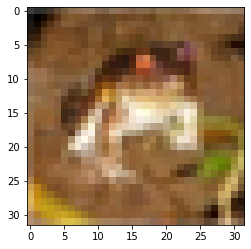

In [34]:
print("Dimensions of an Image: ",x_train.shape[1:3])
plt.figure()
plt.imshow(x_train[0],cmap=plt.cm.binary)
plt.grid(False)
plt.show()

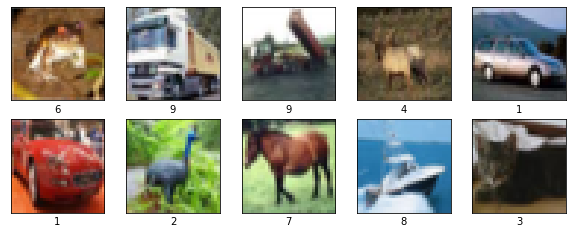

In [35]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(y_train[i])
plt.show()

In [36]:
#Normalisation of x_train and x_test
x_train0to4_norm = x_train0to4 / 255.0
x_train5to9_norm = x_train5to9 / 255.0
x_test0to4_norm = x_test0to4 / 255.0
x_test5to9_norm = x_test5to9 / 255.0
print('Normalization Done')

Normalization Done


In [46]:
x_train0to4_norm.shape

(25000, 32, 3)

### 2. Use One-hot encoding to divide y_train and y_test into required no of output classes

In [0]:
#One-hot encoding the train and test datasets...

y_train0to4_OH = tf.keras.utils.to_categorical(y_train0to4, 5)
y_test0to4_OH = tf.keras.utils.to_categorical(y_test0to4, 5)

#As the second set have values from 5 to 9... when we do one hot encoding, it will end up with 10 index.
#To avoid it subtract the values by 5, so we have values only from 0 to 4, so while doing one hot encoding the index will be 5.
#Converting the y_train and y_test to have values 0 to 4
#y_train5to9 = y_train5to9 - 5
#y_test5to9 = y_test5to9 - 5 

y_train5to9_OH = tf.keras.utils.to_categorical(y_train5to9, 10)
y_test5to9_OH = tf.keras.utils.to_categorical(y_test5to9, 10)

### 3. Build a sequential neural network model which can classify the classes 0 to 4 of CIFAR10 dataset with at least 80% accuracy on test data

In [0]:
#Clear out tensorflow memory
tf.keras.backend.clear_session()
model1 = Sequential()
model1.add(BatchNormalization(input_shape=(32,32,3,)))
model1.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.25))

#Output layer
model1.add(Dense(5, activation='softmax'))

In [0]:
#compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0

In [0]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('model1.h5',save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [61]:
#Train the model
model1.fit(x_train0to4, y_train0to4_OH, validation_data=(x_test0to4,y_test0to4_OH), epochs=20, batch_size=32, callbacks=[model_checkpoint])

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
24960/25000 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9496
Epoch 00001: val_accuracy improved from 0.79700 to 0.79860, saving model to model1.h5
25000/25000 [==============================] - 8s 309us/sample - loss: 0.1432 - accuracy: 0.9496 - val_loss: 0.8219 - val_accuracy: 0.7986
Epoch 2/20
24928/25000 [============================>.] - ETA: 0s - loss: 0.1340 - accuracy: 0.9535
Epoch 00002: val_accuracy did not improve from 0.79860
25000/25000 [==============================] - 7s 299us/sample - loss: 0.1339 - accuracy: 0.9535 - val_loss: 0.8169 - val_accuracy: 0.7972
Epoch 3/20
24896/25000 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9661
Epoch 00003: val_accuracy did not improve from 0.79860
25000/25000 [==============================] - 7s 299us/sample - loss: 0.0995 - accuracy: 0.9659 - val_loss: 0.8635 - val_accuracy: 0.7972
Epoch 4/20
24832/25000 [==============

In [0]:
#Get the predictions of the maodel for train and test dataset...
predictions_train = model1.predict(x_train0to4)
predictions_test = model1.predict(x_test0to4)

In [66]:
#Print the train and test accuracy...
print ("Train Accuracy (0-4 classification): ", metrics.accuracy_score(np.argmax(y_train0to4_OH, axis=1), np.argmax(predictions_train, axis=1)))
print ("Test Accuracy (0-4 classification): ", metrics.accuracy_score(np.argmax(y_test0to4_OH, axis=1), np.argmax(predictions_test, axis=1)))

Train Accuracy (0-4 classification):  0.99688
Test Accuracy (0-4 classification):  0.7982


In [67]:
print ("Classification Report for train data (0-4 classification)")
print(classification_report(np.argmax(y_train0to4_OH, axis=1), np.argmax(predictions_train, axis=1)))

Classification Report for train data (0-4 classification)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5000
           1       1.00      1.00      1.00      5000
           2       0.99      1.00      1.00      5000
           3       1.00      1.00      1.00      5000
           4       1.00      1.00      1.00      5000

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



In [68]:
print ("Classification Report for test data (0-4 classification)")
print(classification_report(np.argmax(y_test0to4_OH, axis=1), np.argmax(predictions_test, axis=1)))

Classification Report for test data (0-4 classification)
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1000
           1       0.93      0.94      0.93      1000
           2       0.70      0.73      0.71      1000
           3       0.73      0.74      0.74      1000
           4       0.78      0.75      0.77      1000

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



##Above model is saved as model1.h5 with 80.940% accuracy

### 4. In the model which was built above (for classification of classes 0-4 in CIFAR10), make only the dense layers to be trainable and conv layers to be non-trainable

In [83]:
#Freezing layers in the model which don't have 'dense' in their name
for layer in model1.layers:
  if('dense' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False
    
#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model1.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'green'))

batch_normalization
False
conv2d
False
batch_normalization_1
False
conv2d_1
False
batch_normalization_2
False
conv2d_2
False
max_pooling2d
False
flatten
False
dense
True
batch_normalization_3
False
dense_1
True
batch_normalization_4
False
dense_2
True
dropout
False
dense_3
True


In [84]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0

### 5. Utilize the the model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10  (Use Transfer Learning) <br>
Achieve an accuracy of more than 85% on test data

In [0]:
#Set pre-trained model layers to not trainable
for layer in model1.layers:
    layer.trainable = True

In [0]:
#Get the output feature shape of pretrained model to pass on to the input of new model.
input_shape = model1.output_shape[1]

model5to9 = Sequential()
model5to9.add(model1)

#Add some dense layer to the pretrained model...
model5to9.add(Dense(128, activation = 'relu', input_dim=input_shape, kernel_initializer = 'he_normal'))
model5to9.add(Dense(10, activation = 'softmax'))

In [90]:
model5to9.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model5to9.fit(x_train5to9, y_train5to9_OH,
                    epochs=20, 
                    validation_data=(x_test5to9, y_test5to9_OH),
                    verbose = 1,
                    initial_epoch=0,batch_size=32)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 9s 350us/sample - loss: 0.9648 - accuracy: 0.6471 - val_loss: 0.7321 - val_accuracy: 0.7412
Epoch 2/20
25000/25000 [==============================] - 8s 305us/sample - loss: 0.6038 - accuracy: 0.7905 - val_loss: 0.5001 - val_accuracy: 0.8202
Epoch 3/20
25000/25000 [==============================] - 8s 309us/sample - loss: 0.4894 - accuracy: 0.8300 - val_loss: 0.4407 - val_accuracy: 0.8436
Epoch 4/20
25000/25000 [==============================] - 8s 305us/sample - loss: 0.4303 - accuracy: 0.8524 - val_loss: 0.4129 - val_accuracy: 0.8504
Epoch 5/20
25000/25000 [==============================] - 8s 308us/sample - loss: 0.3606 - accuracy: 0.8766 - val_loss: 0.3688 - val_accuracy: 0.8742
Epoch 6/20
25000/25000 [==============================] - 8s 303us/sample - loss: 0.3151 - accuracy: 0.8906 - val_loss: 0.3862 - val_accuracy: 0.8644
Epoch 7/20
25000/25000 [===========================

In [0]:
#Get the predictions of the model for train and test dataset...
predictions_train5to9 = model5to9.predict(x_train5to9)
predictions_test5to9 = model5to9.predict(x_test5to9)

In [92]:
#Print the train and test accuracy...
print ("Train Accuracy (5-9 classification): ", metrics.accuracy_score(np.argmax(y_train5to9_OH, axis=1), np.argmax(predictions_train5to9, axis=1)))
print ("Test Accuracy (5-9 classification): ", metrics.accuracy_score(np.argmax(y_test5to9_OH, axis=1), np.argmax(predictions_test5to9, axis=1)))

Train Accuracy (5-9 classification):  0.99368
Test Accuracy (5-9 classification):  0.886


In [93]:
print ("Classification Report for train data (5-9 classification)")
print(classification_report(np.argmax(y_train5to9_OH, axis=1), np.argmax(predictions_train5to9, axis=1)))

Classification Report for train data (5-9 classification)
              precision    recall  f1-score   support

           5       0.99      1.00      1.00      5000
           6       1.00      1.00      1.00      5000
           7       0.99      1.00      0.99      5000
           8       0.99      1.00      0.99      5000
           9       1.00      0.98      0.99      5000

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000



In [94]:
print ("Classification Report for test data (5-9 classification)")
print(classification_report(np.argmax(y_test5to9_OH, axis=1), np.argmax(predictions_test5to9, axis=1)))

Classification Report for test data (5-9 classification)
              precision    recall  f1-score   support

           5       0.82      0.86      0.84      1000
           6       0.91      0.90      0.91      1000
           7       0.86      0.90      0.88      1000
           8       0.89      0.93      0.91      1000
           9       0.96      0.84      0.90      1000

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



# Text classification using TF-IDF

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### 6. Load the dataset from sklearn.datasets

In [0]:
from sklearn.datasets import fetch_20newsgroups

In [0]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

### 7. Training data

In [98]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

### 8. Test data

In [0]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

###  a.  You can access the values for the target variable using .target attribute 
###  b. You can access the name of the class in the target variable with .target_names


In [100]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2])

In [101]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [102]:
twenty_train.data[0:5]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

### 9.  Now with dependent and independent data available for both train and test datasets, using TfidfVectorizer fit and transform the training data and test data and get the tfidf features for both

In [0]:
vect = TfidfVectorizer()
twenty_train_Vect = vect.fit_transform(twenty_train.data)
twenty_test_Vect = vect.transform(twenty_test.data)

### 10. Use logisticRegression with tfidf features as input and targets as output and train the model and report the train and test accuracy score

In [104]:
from sklearn.linear_model import LogisticRegression

#Fit the train features with LogisticRegression...
logreg = LogisticRegression(C=1e9)
logreg.fit(twenty_train_Vect, twenty_train.target)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Predict the values for train and test...
y_pred_train = logreg.predict(twenty_train_Vect)
y_pred_test = logreg.predict(twenty_test_Vect)

In [110]:
print ("Train Accuracy Score: ", str(metrics.accuracy_score(twenty_train.target, y_pred_train)*100) + "%")
print ("Test Accuracy Score: ", str(metrics.accuracy_score(twenty_test.target, y_pred_test)*100) + "%")

Train Accuracy Score:  100.0%
Test Accuracy Score:  91.54460719041279%
